# Machine learning solution - 'Find a comedy' task

In [120]:
# Data helpers
import pandas as pd
import numpy as np

# Modelling algorithms
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Image processing
from skimage.io import imread

# Evaluation
from sklearn.metrics import roc_auc_score

# Visualisation
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [121]:
# Path constants
train_data_path = './data/train.csv'
test_data_path = './data/test.csv'
result_file_path = './predictions.csv'

In [122]:
# Load data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

combined_data = {
    'train': train_data,
    'test': test_data
}

# Feature extraction

## Movie category

Let's investigate our data. We can observe that there are a lot of bit columns represent movie category.

We can make correlation matrix and figure out categories with the lowest correlation on target label. Taking into consideration the fact that a big amount of columns may decrease accuracy of linear models. 

In our case 'Sport' and 'News' have very low correlation score (~0.005 and 0.02).

In [123]:
categories_correlation = train_data[train_data.columns.difference(['Id', 'Poster', 'Duration'])].corr().abs()
categories_correlation['Target'].sort_values()

Sport          0.004458
News           0.018527
Adventure      0.032293
Fantasy        0.037766
Music          0.050680
Musical        0.057900
Western        0.069769
Crime          0.076993
Documentary    0.079898
Sci-Fi         0.090713
War            0.140589
Biography      0.147653
History        0.156832
Horror         0.161735
Romance        0.173307
Action         0.174330
Animation      0.177769
Mystery        0.190259
Family         0.228513
Drama          0.248148
Thriller       0.373698
Target         1.000000
Name: Target, dtype: float64

Also let's check inner correlation of the columns. The features with high inner correlation can descrease linear model accurancy. In our case the biggest inner correlation is ~0.6. That's not a big score, therefore we can include all other category columns into the training set.

In [124]:
unstacked_correlation = categories_correlation.unstack()
max_correlation = unstacked_correlation[unstacked_correlation != 1.0].max()

print(max_correlation)

0.606753960478


## Movie rating

Assumption #1 - the percentage of comedy movies depends on age limit

Take a look at the table below. It represtents the ratio of comedy to the total movies number for a particular rating category.

We can confirm that there is correlation between target and rating values.
The probability of a movie to be considered as a comedy increases when the bigger amount of audience is allowed to watch it due to the age limit:
TV_G => G => PG => PG-13 => R => NC-17.

Unfortinatly, 'X' rating doesn't fit our assumption. Possible it's an outlier.

In [125]:
train_data[['Rating', 'Target']].groupby('Rating', as_index=False)\
    .mean().sort_values(by='Target', ascending=False)

,Rating,Target
11,TV-G,0.800000
1,G,0.593023
6,PG,0.554717
14,X,0.428571
7,PG-13,0.393339
9,R,0.327920
13,Unrated,0.289474
0,Approved,0.275000
8,Passed,0.250000
10,TV-14,0.250000


We will encode 'Rating' categorical column with a numeric value. Also, we will merge equivalent values (e.g. X and NC-17, Unrated and Not Rated).

In [126]:
# Numeric value is increased based on auditory audience restrictions
rate_mapping = {
    'G': 0,
    'PG': 1,
    'PG-13': 2,
    'R': 3,
    'X': 4,
    'Not Rated': 5
}

for data_frame in combined_data.values():
    # Let's consider missing values as Not Rated
    data_frame['Rating'] = data_frame['Rating'].fillna('Not Rated')
    data_frame['Rating'] = data_frame['Rating'].replace(['Unrated',
                                                         'TV-G', 'Approved', 'Passed', 
                                                         'TV-14', 
                                                         'M', 'GP', 
                                                         'NC-17', 'TV-MA'],
                                                        ['Not Rated', 
                                                         'G', 'G', 'G', 
                                                         'PG-13', 
                                                         'PG', 'PG', 
                                                         'X', 'X'])

    data_frame['Rating'] = data_frame['Rating'].map(rate_mapping)

## Poster

Assumption #2 - poster colour scheme correlates with target label.

The main problem here is to represent an image ias a numeral. One of possible approaches is converting a poster to a numeral using mean value of Red channel (for RGB image model). The assumption is that R channel value influences on 'darkness' of a poster.

It's necessary to add that several experiments were conducted with HSV representation but it didn't increase model accuracy. Moreover it decreased overall perfomance.

In [127]:
def get_float_of_poster(img_name):
    image = imread("./task_2_data/posters/{}".format(img_name))
    # get mean value of R channel
    return np.mean(image[:, :, 0])

for data_frame in combined_data.values():
    data_frame['Poster_Float'] = data_frame['Poster'].map(get_float_of_poster)

Let's visualize the results. Indeed, we can observe some correlation on the graphs.

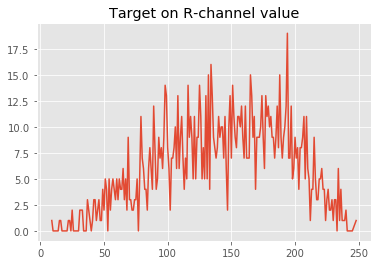

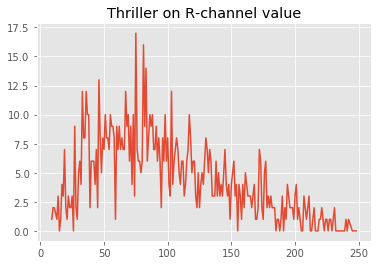

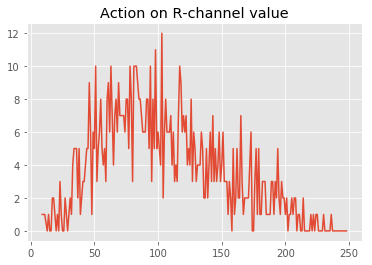

In [128]:
def display_poster_category_chart(category):
    poster_rounded = train_data['Poster_Float'].map(lambda num: round(num, 0))
    poster_data = train_data[[category]].join(poster_rounded).groupby('Poster_Float', as_index=False).sum()
    plt.title('{} on R-channel value'.format(category))
    plt.plot(poster_data[['Poster_Float']], poster_data[category])
    plt.show()

display_poster_category_chart('Target')
display_poster_category_chart('Thriller')
display_poster_category_chart('Action')

# Data preprocessing

Linear algorithms are very sensitive to data scaling. Also we have numeric column 'Duration' which should be also scaled as well. We will scale the data by StandardScaler. 

And also we will exclude the extra columns.

In [129]:
scaled_features = {}
scaler = StandardScaler()

for name, data_frame in combined_data.items():
    features = data_frame[data_frame.columns.difference(['Id', 'Target',
                                                         'Language', 'Country',
                                                         'Poster',
                                                         'Sport', 'News'
                                                         ])]
    
    scaled_features[name] = scaler.fit_transform(features)

# Model training

We will split our training data and apply several machine learning models.

In [130]:
train, test, train_labels, test_labels = train_test_split(scaled_features['train'], train_data['Target'], test_size=0.20)

trained_models = {'Logistic Regression': LogisticRegression().fit(train, train_labels),
                  'Linear Regression': LinearRegression().fit(train, train_labels),
                  'SVC': SVC().fit(train, train_labels),
                  'Naive Bayes': GaussianNB().fit(train, train_labels),
                  'Decision Tree Classifier': DecisionTreeClassifier().fit(train, train_labels)}

# Evaluation

In [131]:
scores = []
for model_name, model in trained_models.items():
    scores.append((model_name, roc_auc_score(test_labels, model.predict(test))))

scores.sort(key=lambda row: row[1], reverse=True)

for name, score in scores:
    print('{} - {}'.format(name, score))

Linear Regression - 0.8875284738041002
SVC - 0.8133304859529232
Logistic Regression - 0.7990659010377119
Naive Bayes - 0.7863950582131106
Decision Tree Classifier - 0.7192720197418376


Based on the score results we can choose a model with the highest AUC score - Linear Regression model.
It's score ~ 0.9

# Output results

In [131]:
final_model = LinearRegression().fit(scaled_features['train'], train_data['Target'])

probabilities = final_model.predict(scaled_features['test'])
probabilities[probabilities < 0] = 0
probabilities = probabilities.round(6)

dump_frame = pd.DataFrame(test_data[['Id']])
dump_frame['Probability'] = probabilities

dump_frame.to_csv(result_file_path)

# Final Notes:

As we've just prooved, the best results were obtained by linear models. It indicates that the chosen features have strong linear relationship.

Language and Country columns were excluded after several tries of their integration. Obviously we cannot encode them by numerials as we did with Rating variable. One-hot-encoding method was tested on the training dataset. But it didn't improve score of models and even decreased some scores. One possible approach is to extract additional features based on exisiting ones(e.g. Country_Rating). Also, we can try to use non-linear models (Decision Tree or Bayes) particulary for these columns and combine their scores with the final model results.